Ponerlo en el env


Para empezar a usar dask:
pip install dask o pip install dask[complete]


pip install graphviz

In [2]:
import numpy as np
import pandas as pd
import urllib
import os

import dask
import dask.dataframe as dd
import dask.array as da
import dask.bag as db

# No todos los imports son necesarios, depende del tipo de datos con el que estes trabajando.

## Dask Bag

In [3]:
bg = db.from_sequence([1,2,3,4,5,6,7,8,9,10], npartitions = 2)
bg
# bg.compute()
# res = list(bg)

dask.bag<from_sequence, npartitions=2>

In [4]:
# Lectura de archivos de texto a bags y viceversa
# bg2 = db.read_text('example.txt')
# bg2.to_textfiles(dir/)

## Dask Array

Un dask array se compone de varios numpy arrays, a los que llamaremos "chunks".

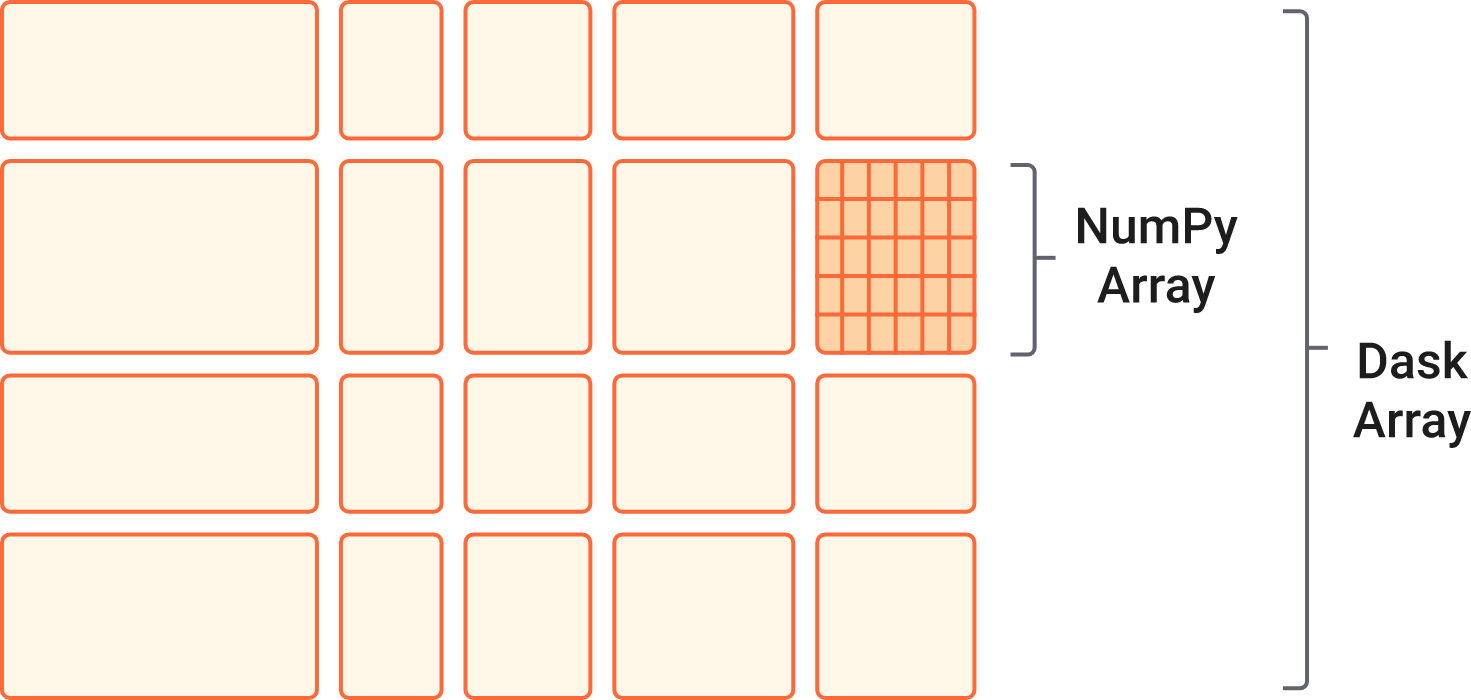

Para optimizar el uso de dask arrays tenemos que escoger adecuadamente el tamaño de nuestros chunks.
- Si son muy grandes entonces nos terminaremos el espacio en memoria.
- Si son muy pequeños entonces dask puede perder su funcionalidad.
* Tamaño óptimo: entre 100MB y 1G. Número de cores * 2


Por lo tanto, debemos de alinear el número de chunks con nuestro formato en dicso. Si los chunks no son múltiplo  podríamos hacer que Dask pierda eficiencia, haciendo que repita múltiples veces lo que ya hicimos antes.

Expensive!


Por ejemplo, si tenemos un file que tiene chunks de tamaños (128,64) ahora tenemos que escoger un array con chunks de (1280, 64000).

In [5]:
x = da.random.random((10000, 10000), chunks=(1000, 1000))
x
# x.compute()

dask.array<random_sample, shape=(10000, 10000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

Hay varias maneras de usar los chunks:
- bloques simetricos --> chunks = n
- bloques asimetricos --> chunks = (n,m)
- bloques asimetricos sin repeticion --> chunks = ((2,4),(3,3)) o chunks = ((5,5,5,5),(8,8,8))
- sin usar chunks --> chunks = None

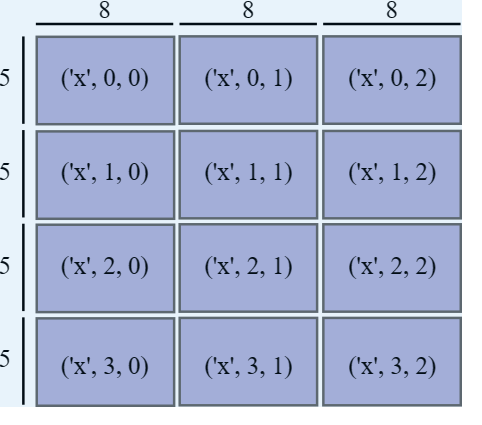


In [6]:
y = da.random.random((10000, 10000), chunks='auto')  # optimiza la cantidad de chunks
y
# y.compute()
# Si necesitamos cambiar el lay-out de los chunks podemos usar rechunk()
# Si necesitamlos cambiar la estructura del dask array usamos reshape()

dask.array<random_sample, shape=(10000, 10000), dtype=float64, chunksize=(4096, 4096), chunktype=numpy.ndarray>

**`Xarray`**

Es un package wrap que te ofrece algunos extras para trabajar con datasets mas complicados. Te permite:
1. Manejar multiples datasets y ordenarlos de manera cohesiva como un solo dataset.
2. Leer de varios stacks al mismo tiempo.
3. Intercambiar el uso de dask array y munpy array.


**`Operaciones`**

 - dask.array.blockwise(func, out_ind, *args[, name, ...])

 - map_blocks(func, *args[, name, token, ...])

 - map_overlap(func, *args[, depth, boundary, ...])

 - reduction(x, chunk, aggregate[, axis, ...])


**`Slicing`**

In [7]:
s1 = x[0, :15]
s1
# s1.compute()

dask.array<getitem, shape=(15,), dtype=float64, chunksize=(15,), chunktype=numpy.ndarray>

In [8]:
s2 = x[[1,28,62]]
s2
# s2.compute()

dask.array<getitem, shape=(3, 10000), dtype=float64, chunksize=(3, 1000), chunktype=numpy.ndarray>

In [9]:
s3 = y[y < 0.468]
s3
# s3.compute()

dask.array<getitem, shape=(nan,), dtype=float64, chunksize=(nan,), chunktype=numpy.ndarray>

Documentacion del Indexing : _https://docs.dask.org/en/stable/array-assignment.html_

**`Stack y Concat`**

In [10]:
arr1 = da.from_array(np.zeros((3, 4)), chunks=(1, 2))
arr2 = da.from_array(np.ones((3, 4)), chunks=(1, 2))

arr1.compute()


array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [11]:
arr2.compute()

array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]])

In [12]:
data = [arr1,arr2]
x = da.stack(data, axis=0)
y = da.stack(data, axis=1)

x

dask.array<stack, shape=(2, 3, 4), dtype=float64, chunksize=(1, 1, 2), chunktype=numpy.ndarray>

In [13]:
y

dask.array<stack, shape=(3, 2, 4), dtype=float64, chunksize=(1, 1, 2), chunktype=numpy.ndarray>

In [14]:
a = da.concatenate(data, axis=0)
b = da.concatenate(data, axis=1)

a

dask.array<concatenate, shape=(6, 4), dtype=float64, chunksize=(1, 2), chunktype=numpy.ndarray>

In [15]:
b

dask.array<concatenate, shape=(3, 8), dtype=float64, chunksize=(1, 2), chunktype=numpy.ndarray>

## Dask Dataframes


Un dataframe de Dask se compone de dataframes de pandas

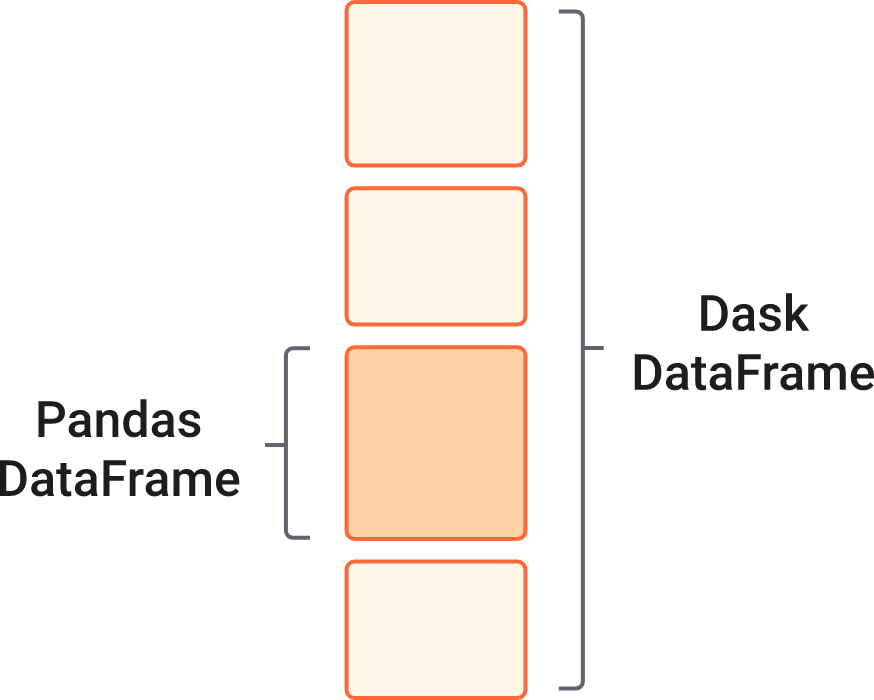

**Usos**
1. Manipulacion de datasets muy grandes, incluso aquellos que exceden la memoria disponible.
2. Aceleracion de los procesos.
3. Distribucion de tareas usando como apoyo pandas.

**Limitaciones**
1. Indexar una columna desordenada.
2. groupby, join --> expensive.
3. Dask no implementa algunas funciones de pandas.

**`Creando el Dataframe`**

In [16]:
# Ejemplo

# Primero creamos un dataframe
index = pd.date_range("2020-07-03", periods=2400, freq="1H")
df = pd.DataFrame({"a": np.arange(2400), "b": list("abcaddbe" * 300)}, index=index)
# df

# Luego, podemos agregar las particiones que queramos al dataframe usando dask
ddf = dd.from_pandas(df, npartitions=10)  # (dataframe a usar, numero de particiones que queremos)
ddf
# ddf.compute()

,a,b
npartitions=10,,
2020-07-03 00:00:00,int32,object
2020-07-13 00:00:00,...,...
...,...,...
2020-10-01 00:00:00,...,...
2020-10-10 23:00:00,...,...


In [17]:
#Revisando la estructura del dataframe

ddf.map_partitions(type).compute()

0    <class 'pandas.core.frame.DataFrame'>
1    <class 'pandas.core.frame.DataFrame'>
2    <class 'pandas.core.frame.DataFrame'>
3    <class 'pandas.core.frame.DataFrame'>
4    <class 'pandas.core.frame.DataFrame'>
5    <class 'pandas.core.frame.DataFrame'>
6    <class 'pandas.core.frame.DataFrame'>
7    <class 'pandas.core.frame.DataFrame'>
8    <class 'pandas.core.frame.DataFrame'>
9    <class 'pandas.core.frame.DataFrame'>
dtype: object

In [18]:
div = ddf.divisions # nos permite checar los intervalos de cada partición
print(div)

# Accediendo a una partición específica, tiene formato df
p1 = ddf.partitions[1]
p1
# p1.compute()

# Tambien podemos utilizar repartition para volver a asignar recursos.
# DataFrame.repartition(divisions=[1,10,50, 100, ... , 2400], npartitions=None, partition_size=None, freq='12h', force=False)

(Timestamp('2020-07-03 00:00:00', freq='H'), Timestamp('2020-07-13 00:00:00', freq='H'), Timestamp('2020-07-23 00:00:00', freq='H'), Timestamp('2020-08-02 00:00:00', freq='H'), Timestamp('2020-08-12 00:00:00', freq='H'), Timestamp('2020-08-22 00:00:00', freq='H'), Timestamp('2020-09-01 00:00:00', freq='H'), Timestamp('2020-09-11 00:00:00', freq='H'), Timestamp('2020-09-21 00:00:00', freq='H'), Timestamp('2020-10-01 00:00:00', freq='H'), Timestamp('2020-10-10 23:00:00', freq='H'))


,a,b
npartitions=1,,
2020-07-13,int32,object
2020-07-23,...,...


In [19]:
# Revisando como se ocupa la memoria
mem = ddf.memory_usage_per_partition(index=True, deep=True)
mem.compute()

0    16800
1    16800
2    16800
3    16800
4    16800
5    16800
6    16800
7    16800
8    16800
9    16800
dtype: int64

**Ejemplo de sintaxis si queremos leer de un csv file**


ddf2 = dd.read_csv('nombre del file.csv', blocksize = 80e6) # 80MB por cada particion
ddf2


**Aprovechndo la similitud de los nombres de archivo**


ddf3 = dd.read_csv('2000-*-*.csv', parse_dates = ['timestamp'])         
ddf3

In [20]:
# Otro ejemplo de dataframes

print("- Downloading NYC Flights dataset... ", end='', flush=True)
url = "https://storage.googleapis.com/dask-tutorial-data/nycflights.tar.gz"
filename, headers = urllib.request.urlretrieve(url, 'nycflights.tar.gz')
print("Done!", flush=True)

- Downloading NYC Flights dataset... Done!


In [21]:

df2 = dd.read_csv(os.path.join('data', 'nycflights', '*.csv'),
                 parse_dates={'Date': [0, 1, 2]},
                 assume_missing=True)

df2

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
npartitions=6,,,,,,,,,,,,,,,,,,,,,
,datetime64[ns],float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,object,object,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [22]:
df2.head()

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990-01-01,1.0,1621.0,1540.0,1747.0,1701.0,US,33.0,NaN,86.0,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,0.0,0.0
1,1990-01-02,2.0,1547.0,1540.0,1700.0,1701.0,US,33.0,NaN,73.0,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,0.0,0.0
2,1990-01-03,3.0,1546.0,1540.0,1710.0,1701.0,US,33.0,NaN,84.0,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,0.0,0.0
3,1990-01-04,4.0,1542.0,1540.0,1710.0,1701.0,US,33.0,NaN,88.0,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,0.0,0.0
4,1990-01-05,5.0,1549.0,1540.0,1706.0,1701.0,US,33.0,NaN,77.0,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,0.0,0.0


In [23]:
df2.columns

Index(['Date', 'DayOfWeek', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime',
       'UniqueCarrier', 'FlightNum', 'TailNum', 'ActualElapsedTime',
       'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Origin', 'Dest',
       'Distance', 'TaxiIn', 'TaxiOut', 'Cancelled', 'Diverted'],
      dtype='object')

In [20]:
df2.tail()

ValueError: Mismatched dtypes found in `pd.read_csv`/`pd.read_table`.

+---------+--------+----------+
| Column  | Found  | Expected |
+---------+--------+----------+
| TailNum | object | float64  |
+---------+--------+----------+

The following columns also raised exceptions on conversion:

- TailNum
  ValueError("could not convert string to float: 'N14342'")

Usually this is due to dask's dtype inference failing, and
*may* be fixed by specifying dtypes manually by adding:

dtype={'TailNum': 'object'}

to the call to `read_csv`/`read_table`.

In [21]:
df2 = dd.read_csv(os.path.join('data', 'nycflights', '*.csv'),
                 parse_dates={'Date': [0, 1, 2]},
                 dtype={'TailNum': str},
                 assume_missing=True)

In [22]:
df2.tail()

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
70320,1995-04-06,4.0,2013.0,2015.0,2250.0,2257.0,CO,751.0,N14980,157.0,...,128.0,-7.0,-2.0,EWR,MCO,938.0,6.0,23.0,0.0,0.0
70321,1995-04-07,5.0,2016.0,2015.0,2250.0,2257.0,CO,751.0,N16883,154.0,...,126.0,-7.0,1.0,EWR,MCO,938.0,5.0,23.0,0.0,0.0
70322,1995-04-08,6.0,2034.0,2015.0,2312.0,2257.0,CO,751.0,N11984,158.0,...,129.0,15.0,19.0,EWR,MCO,938.0,9.0,20.0,0.0,0.0
70323,1995-04-09,7.0,2051.0,2015.0,2318.0,2257.0,CO,751.0,N13983,147.0,...,121.0,21.0,36.0,EWR,MCO,938.0,6.0,20.0,0.0,0.0
70324,1995-04-10,1.0,201.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
df2.compute()

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990-01-01,1.0,1621.0,1540.0,1747.0,1701.0,US,33.0,NaN,86.0,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,0.0,0.0
1,1990-01-02,2.0,1547.0,1540.0,1700.0,1701.0,US,33.0,NaN,73.0,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,0.0,0.0
2,1990-01-03,3.0,1546.0,1540.0,1710.0,1701.0,US,33.0,NaN,84.0,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,0.0,0.0
3,1990-01-04,4.0,1542.0,1540.0,1710.0,1701.0,US,33.0,NaN,88.0,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,0.0,0.0
4,1990-01-05,5.0,1549.0,1540.0,1706.0,1701.0,US,33.0,NaN,77.0,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70320,1995-04-06,4.0,2013.0,2015.0,2250.0,2257.0,CO,751.0,N14980,157.0,...,128.0,-7.0,-2.0,EWR,MCO,938.0,6.0,23.0,0.0,0.0
70321,1995-04-07,5.0,2016.0,2015.0,2250.0,2257.0,CO,751.0,N16883,154.0,...,126.0,-7.0,1.0,EWR,MCO,938.0,5.0,23.0,0.0,0.0
70322,1995-04-08,6.0,2034.0,2015.0,2312.0,2257.0,CO,751.0,N11984,158.0,...,129.0,15.0,19.0,EWR,MCO,938.0,9.0,20.0,0.0,0.0
70323,1995-04-09,7.0,2051.0,2015.0,2318.0,2257.0,CO,751.0,N13983,147.0,...,121.0,21.0,36.0,EWR,MCO,938.0,6.0,20.0,0.0,0.0


In [31]:
df2.describe().compute()

,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,FlightNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
count,1.383331e+06,1.353762e+06,1.383330e+06,1.349856e+06,1.383330e+06,1.383330e+06,1.349856e+06,1.383297e+06,69944.000000,1.349856e+06,1.353761e+06,1.381835e+06,70324.000000,70324.000000,1.383330e+06,1.383330e+06
mean,3.909684e+00,1.354817e+03,1.346016e+03,1.525960e+03,1.531578e+03,7.385972e+02,1.515442e+02,1.528416e+02,135.220862,6.564600e+00,8.472505e+00,8.437756e+02,6.112636,19.618921,2.137523e-02,2.822898e-03
std,1.983435e+00,4.581968e+02,4.481485e+02,4.814817e+02,4.636213e+02,5.934904e+02,8.084441e+01,7.977442e+01,83.477934,3.169391e+01,2.602491e+01,6.200608e+02,4.786990,9.711615,1.446318e-01,5.305593e-02
min,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,-1.300000e+01,0.000000e+00,12.000000,-1.437000e+03,-5.300000e+02,1.100000e+01,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,2.000000e+00,9.260000e+02,9.200000e+02,1.136000e+03,1.135000e+03,3.170000e+02,9.600000e+01,1.000000e+02,71.000000,-8.000000e+00,0.000000e+00,4.310000e+02,4.000000,13.000000,0.000000e+00,0.000000e+00
50%,4.000000e+00,1.430000e+03,1.430000e+03,1.538000e+03,1.546000e+03,6.810000e+02,1.490000e+02,1.530000e+02,121.000000,1.000000e+00,1.000000e+00,7.600000e+02,5.000000,18.000000,0.000000e+00,0.000000e+00
75%,6.000000e+00,1.801000e+03,1.755000e+03,1.952000e+03,1.948000e+03,1.472000e+03,1.970000e+02,1.940000e+02,165.000000,1.400000e+01,7.000000e+00,1.097000e+03,7.000000,23.000000,0.000000e+00,0.000000e+00
max,7.000000e+00,2.400000e+03,2.359000e+03,2.400000e+03,2.400000e+03,9.851000e+03,7.030000e+02,7.260000e+02,419.000000,9.910000e+02,1.435000e+03,2.586000e+03,150.000000,200.000000,1.000000e+00,1.000000e+00


**`Indexing`**

Para poder indexar los objetos de dask podemos hacerlo similar a como usualmente lo haciamos en pandas.

Tambien podemos utilizar la funcion set_index() pero con poca frecuencia porque la operacion es muy costosa. Sirve para reducir el tiempo de ejecucion. Similar a SQL.

In [ ]:
# ddf.b nos permite ver la estructura de una columna
slice1 = ddf["2020-09-01": "2020-11-01 5:00"]
slice1
# slice1.compute()

# ddf = df.set_index('timestamp')  # set the index 

# ddf.loc['2001-01-05':'2001-01-12']  
# df.merge(df2, left_index=True, right_index=True)  

,a,b
npartitions=4,,
2020-09-01 00:00:00,int32,object
2020-09-11 00:00:00,...,...
2020-09-21 00:00:00,...,...
2020-10-01 00:00:00,...,...
2020-10-10 23:00:00,...,...


**`Joins`**

Dask permite:
1. Hacer join de 2 dataframes de dask (single partition)
2. Hacer join de 2 dataframes de dask utilizando los indices
3. Hacer join de un dataframe de dask con un dataframe de pandas

**`Persist`**

Usualmente cuando utilizamos dask dataframes el proceso de tasks es el siguiente:

1. Cargamos los datos de un archivo
2. Filtrar los datos a un subset en particular
3. "Shuffle data" 
(LFS : Load, Filter, Shuffle)
4. Hacer queries con el indexado anterior

Es ideal aplicar el proceso LFS para mantener los datos resultantes en memoria, y así despues utilizarlos varias veces sin tener que repetir la misma descarga de datos una y otra vez.

**Don't do this**

client.persist(df)  # persist doesn't change the input in-place

**Do this instead**

df = client.persist(df)  # replace your old lazy DataFrame

**`Computation`**: "Dask is lazily evaluated"

In [ ]:
# Cada que tu quieras obtener el resultado de una operacion debes usar .compute()
slice1.compute()

,a,b
2020-09-01 00:00:00,1440,a
2020-09-01 01:00:00,1441,b
2020-09-01 02:00:00,1442,c
2020-09-01 03:00:00,1443,a
2020-09-01 04:00:00,1444,d
...,...,...
2020-10-10 19:00:00,2395,a
2020-10-10 20:00:00,2396,d
2020-10-10 21:00:00,2397,d
2020-10-10 22:00:00,2398,b


df = dd.read_csv('s3://bucket/path/to/*.csv')
df = df[df.balance < 0]
df = client.persist(df)

df = df.set_index('timestamp')
df = client.persist(df)

--> df.customer_id.nunique().compute()

18452844

In [ ]:
%time 

#Retomando el ejemplo de los vuelos
df2.Distance.max().compute()

CPU times: total: 0 ns
Wall time: 0 ns


2586.0

In [ ]:
# df2.DepDelay.max().visualize(rankdir="LR", size="12, 12!")

**`Funciones y Metodos`**

Hay algunas funciones de Dask que coinciden con las existentes de pandas. Para cada funcion solo hay que llamarla y darle .compute() para obtener los resultados.

Algunas funciones : read_csv(), head(), tail(), dropna(), fillna(), persist(), nunique(), pivot_table(), repartition(), pipe(), etc.

In [ ]:
# Algunos ejemplos de funciones
ej1 = ddf.a.mean() 
ej1.compute()

# Si tenemos un dataframe muy grande para ahorrarnos tiempo y memoria podemos usar particiones

1199.5

In [ ]:
# unique similar a distinct
ej2 = ddf.b.unique()
ej2.compute()

0    a
1    b
2    c
3    d
4    e
Name: b, dtype: object

Tambien podemos encadenar las funciones como en pandas

In [ ]:
res = slice1.a.cumsum() - 42
res.compute()

2020-09-01 00:00:00       1398
2020-09-01 01:00:00       2839
2020-09-01 02:00:00       4281
2020-09-01 03:00:00       5724
2020-09-01 04:00:00       7168
                        ...   
2020-10-10 19:00:00    1833088
2020-10-10 20:00:00    1835484
2020-10-10 21:00:00    1837881
2020-10-10 22:00:00    1840279
2020-10-10 23:00:00    1842678
Freq: H, Name: a, Length: 960, dtype: int32

In [ ]:
# Podemos tomar las columnas que queramos como en pandas
df_train = df2[['CRSDepTime',  'CRSArrTime', 'Cancelled']]
df_train
# df_train.compute()

,CRSDepTime,CRSArrTime,Cancelled
npartitions=6,,,
,float64,float64,float64
,...,...,...
...,...,...,...
,...,...,...
,...,...,...


In [ ]:
df_train.shape

(Delayed('int-bbf3c3b2-f0c1-4076-bb2d-c930c229cc3d'), 3)

**`Dask does Tasks`**

Siempre tenemos que llamar compute() para poder obtener los resultados. 

Pero tambien podemos usar las funciones .dask y .visualize() para ver las "tasks" que llevara a cabo Dask, ya sea en formato lista o diagrama


In [ ]:
ej1.dask # Lista de pasos
# ej1.visualize() # Diagrama

HighLevelGraph with 7 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x1aad6a069e0>
 0. from_pandas-96367c21b264851aed24fc1821efd34c
 1. getitem-c736fabaaf1fa17adc4514eadaff6465
 2. series-count-chunk-06817e1923bc0c5544af133abfe26928-d50c6b84d0df8f9ec44fb0350847b40c
 3. series-count-agg-06817e1923bc0c5544af133abfe26928
 4. series-sum-chunk-3a41bb6afbe128b21f7c64b5a9541471-7fce84d23c11744f1daf8973ad8d5b28
 5. series-sum-agg-3a41bb6afbe128b21f7c64b5a9541471
 6. series-mean-fc25077e09e8fb543e5fd04ff2a3b9bc-95931f3ca5fc38e8ca77db582e753a1a

Documentacion de todas las funciones de los dataframes : _https://docs.dask.org/en/stable/dataframe-api.html_